In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [29]:
import json
rouge=json.load(open('data/machine_translation_bleu.json'))
# rouge = json.load(open('data/text_summarization_rouge.json'))
# print(rouge)

<Axes: xlabel='age'>

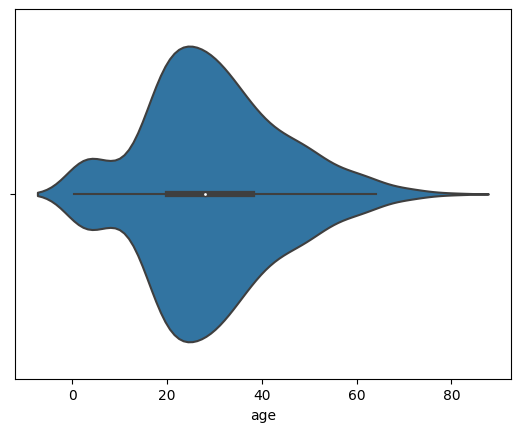

In [40]:
df = sns.load_dataset("titanic")
sns.violinplot(x=df["age"])
# print(df['age'])

In [43]:
# nested dict to dataframe
def map_wp_str(wp_str):
    if "Delta" in wp_str:
        return "$\delta$"
    elif "Gamma" in wp_str:
        return "$\gamma$"
    else:
        return wp_str
        
df = pd.DataFrame.from_dict(
    [{"wp": map_wp_str(wp_str), "score": score_str, "value": score} 
     for wp_str in rouge for score_str in ['precision', 'recall', 'f1'] for score in rouge[wp_str][score_str]],
                            )
df.head()

,wp,score,value
0,None,precision,-0.004320
1,None,precision,0.218466
2,None,precision,0.278335
3,None,precision,0.154689
4,None,precision,0.167793


<Axes: xlabel='wp', ylabel='value'>

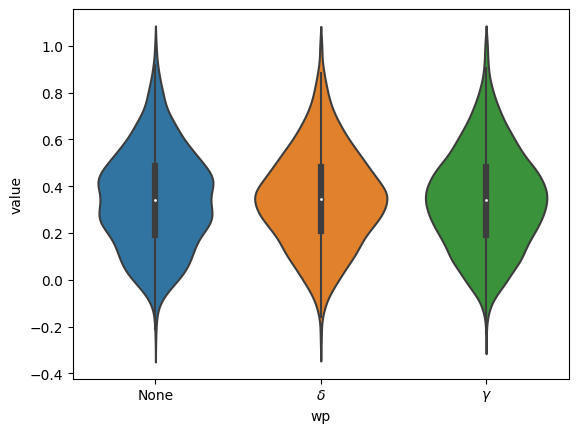

In [47]:
import seaborn as sns
show_wp = ["None", "$\delta$", "$\gamma$"]
sns.violinplot(data=df[df['score']=='precision'], x="wp", y="value",
order=show_wp)